In [5]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import itertools
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

In [6]:
CLASS_NAMES = ["NORMAL", "PNEUMONIA"]

In [7]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory("chest_xray/train", label_mode="categorical",
                                                               class_names=CLASS_NAMES, image_size=(224, 224),
                                                               shuffle=True, seed=42, batch_size=None)
test_ds = tf.keras.preprocessing.image_dataset_from_directory("chest_xray/test", label_mode="categorical",
                                                              class_names=CLASS_NAMES, image_size=(224, 224),
                                                              shuffle=True, seed=42, batch_size=None)
val_ds = tf.keras.preprocessing.image_dataset_from_directory("chest_xray/val", label_mode="categorical",
                                                             class_names=CLASS_NAMES, image_size=(224, 224),
                                                             shuffle=True, seed=42, batch_size=None)

Found 5216 files belonging to 2 classes.
Found 624 files belonging to 2 classes.
Found 16 files belonging to 2 classes.


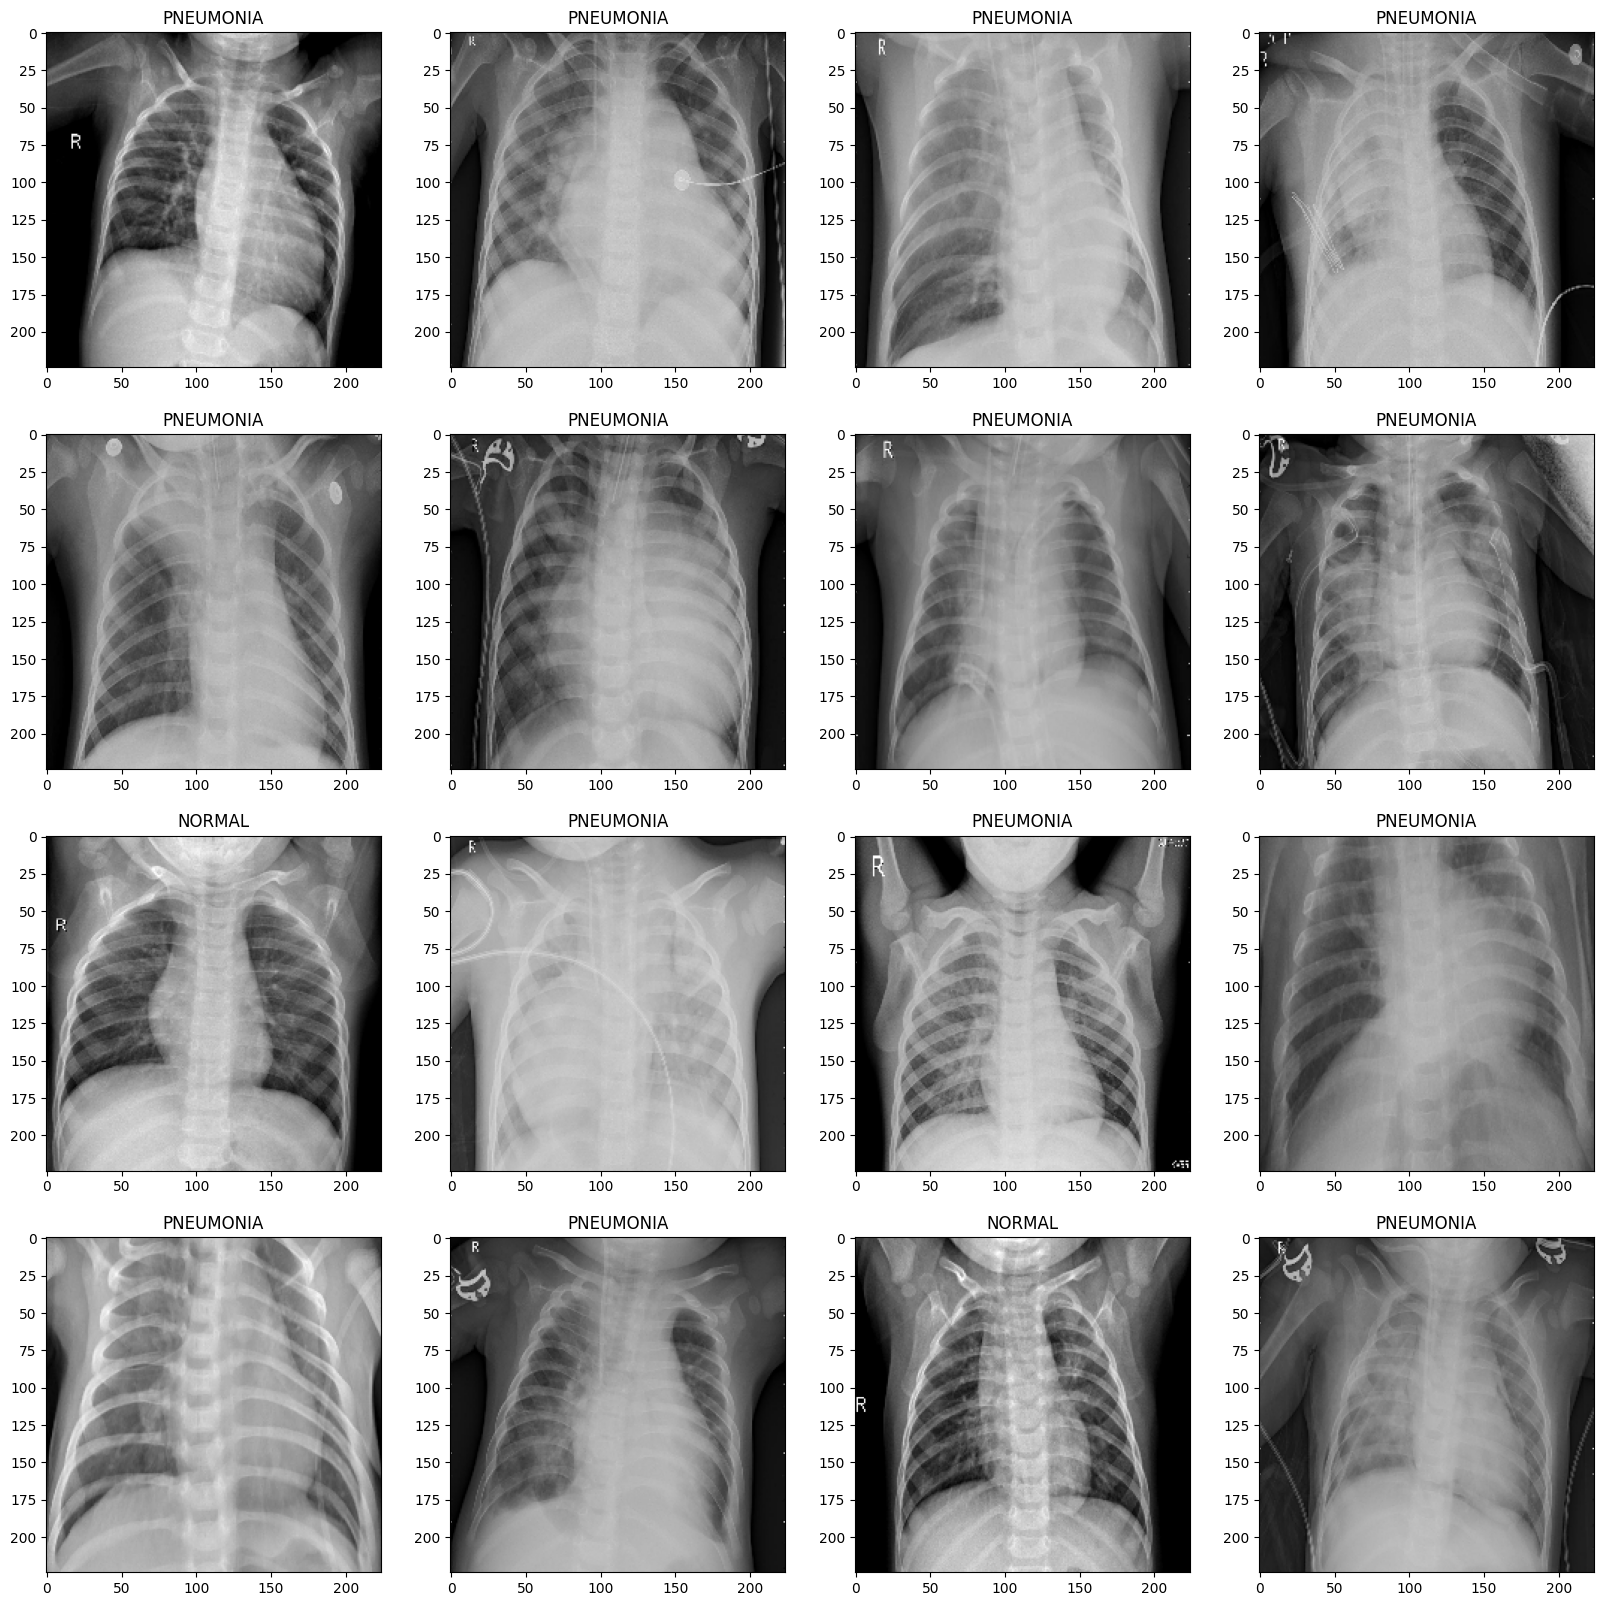

In [8]:
row, col = 4, 4
fig, axes = plt.subplots(row, col, figsize=(20, 20))

for index, x in enumerate(train_ds):
    axes[index // row, index % col].imshow(x[0].numpy().astype(int))
    axes[index // row, index % col].set_title(CLASS_NAMES[x[1].numpy().argmax()])

    if index == (row * col) - 1:
        break

plt.show()

In [9]:
BATCH_SIZE = 32
IMG_SIZE = [256, 256]

def func(image, label):
    return tf.image.resize(image, IMG_SIZE), label

train = train_ds.map(func).batch(BATCH_SIZE).shuffle(1000).prefetch(tf.data.AUTOTUNE).cache()
test = test_ds.map(func).batch(BATCH_SIZE).shuffle(1000).prefetch(tf.data.AUTOTUNE)
val = val_ds.map(func).batch(BATCH_SIZE).shuffle(1000).prefetch(tf.data.AUTOTUNE)

In [10]:
def create_model():
    efficient_net = tf.keras.applications.VGG19(include_top=False, weights="imagenet", input_shape=IMG_SIZE + [3])
    efficient_net.trainable = False
    x = tf.keras.layers.GlobalAveragePooling2D()(efficient_net.output)
    outputs = tf.keras.layers.Dense(len(CLASS_NAMES), activation="softmax")(x)
    model = tf.keras.Model(efficient_net.input, outputs)

    model.compile(
        loss="categorical_crossentropy",
        optimizer=tf.keras.optimizers.Adam(),
        metrics=["accuracy"]
    )
    return model

In [11]:
model = create_model()

In [12]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 256, 256, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 256, 256, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 128, 128, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 128, 128, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 64, 64, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 64, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 64, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, 64, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 32, 32, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 32, 32, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 32, 32, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, 32, 32, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 16, 16, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv4 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2)              │         1,026 │
└─────────────────────────────────┴────────────────────────┴─────────────

 Total params: 20,025,410 (76.39 MB)

 Trainable params: 1,026 (4.01 KB)

 Non-trainable params: 20,024,384 (76.39 MB)

In [13]:
class ModelCheckpointCustom(tf.keras.callbacks.Callback):

    def __init__(self, model_path, save_best_only=False):
        super(ModelCheckpointCustom, self).__init__()

        self.model_path = model_path
        self.save_best_only = save_best_only
        self.best_val_loss = float('inf')

    def on_epoch_end(self, epoch, logs=None):

        current_val_loss = 0 if logs['val_loss'] is None else logs['val_loss']

        if self.save_best_only and current_val_loss < self.best_val_loss:
            self.best_val_loss = current_val_loss
            self.model.save_weights(self.model_path)
        else:
            self.model.save_weights(self.model_path)

save_callbacks = ModelCheckpointCustom(model_path='saved_weights/model.weights.h5', save_best_only=True)

In [14]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="loss", patience=5)

In [15]:
import os

# Make sure the directory exists
os.makedirs("saved_weights", exist_ok=True)

In [17]:
EPOCHS = 5
history = model.fit(train, epochs=EPOCHS, validation_data=val, validation_steps = int(len(val) * 0.2),
                    callbacks=[early_stopping, save_callbacks])

Epoch 1/5


163/163 ━━━━━━━━━━━━━━━━━━━━ 563s 3s/step - accuracy: 0.8848 - loss: 0.2861 - val_accuracy: 0.8125 - val_loss: 0.2432
Epoch 2/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 522s 3s/step - accuracy: 0.9550 - loss: 0.1174 - val_accuracy: 0.8750 - val_loss: 0.2232
Epoch 3/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 504s 3s/step - accuracy: 0.9681 - loss: 0.0856 - val_accuracy: 0.8750 - val_loss: 0.2378
Epoch 4/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 504s 3s/step - accuracy: 0.9731 - loss: 0.0713 - val_accuracy: 0.8750 - val_loss: 0.2595
Epoch 5/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 505s 3s/step - accuracy: 0.9739 - loss: 0.0630 - val_accuracy: 0.8750 - val_loss: 0.2821


<Axes: >

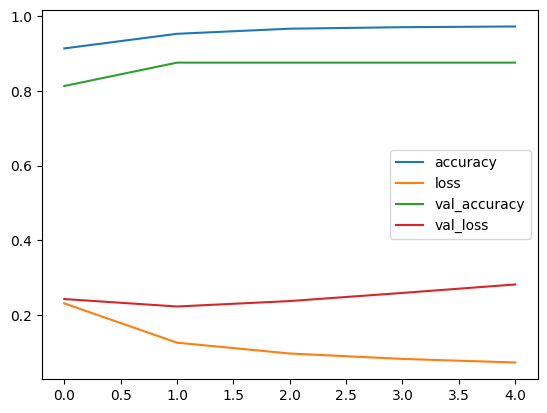

In [18]:
pd.DataFrame(history.history).plot()

# Test the model

In [19]:
loaded_model = create_model()

In [20]:
loaded_model.load_weights("saved_weights/model.weights.h5")

c:\Users\gchan\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 6 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [21]:
y_pred = loaded_model.evaluate(test)

20/20 ━━━━━━━━━━━━━━━━━━━━ 61s 3s/step - accuracy: 0.8172 - loss: 0.5805


In [22]:
print("Testing accuracy:", y_pred[1])

Testing accuracy: 0.8092948794364929


# XAI

In [23]:
class GradCAM(object):

    def __init__(self, model, alpha=0.8, beta=0.3):

        self.model = model
        self.alpha = alpha
        self.beta = beta

    def apply_heatmap(self, heatmap, image):
        # Resize the heatmap to match the size of the original image
        heatmap = cv2.resize(heatmap, image.shape[:-1])

        # Apply color map (JET) to the heatmap
        heatmap = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)

        # Combine the original image and heatmap
        superimposed_img = cv2.addWeighted(np.array(image).astype(np.float32), self.alpha,
                                           np.array(heatmap).astype(np.float32), self.beta, 0)

        return np.array(superimposed_img).astype(np.uint8)

    def gradCAM(self, x_test=None, name='black_max_pool_2', index_class=0):

        with tf.GradientTape() as tape:
             # Get the specified layer from the model
            last_conv_layer = self.model.get_layer(name)

            # Create a new model that outputs the predicted class and the output of the specified layer
            grad_model = tf.keras.Model([self.model.input], [self.model.output, last_conv_layer.output])

            # Get the model predictions and the output of the specified layer for the input image
            model_out, last_conv_layer = grad_model(np.expand_dims(x_test, axis=0))

            # Extract the predicted class output
            class_out = model_out[:, index_class]

            # Compute the gradients of the predicted class output with respect to the last convolutional layer
            grads = tape.gradient(class_out, last_conv_layer)

            # Compute the average gradient values across the spatial dimensions (8x8) and the channels (1152)
            pooled_grads = tf.reduce_mean(grads, axis=(0, 3)) # (1, 8, 8, 1152) -> (8, 8)

            # Compute the average activation values across the spatial dimensions (8x8) and the channels (1152)
            last_conv_layer = tf.reduce_mean(last_conv_layer, axis=(0, 3))

        # Element-wise multiplication of the gradients and the activation values
        heatmap = tf.multiply(pooled_grads, last_conv_layer)

        # Set negative values to zero
        heatmap = np.maximum(heatmap, 0)

        # Normalize the heatmap values between 0 and 1
        heatmap /= np.max(heatmap)
        heatmap = np.array(heatmap)

        # Apply the heatmap on the input image and return the result
        return self.apply_heatmap(heatmap, x_test)

In [24]:
gradCam = GradCAM(loaded_model, alpha=0.8, beta=0.2)

c:\Users\gchan\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\models\functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_24']
Received: inputs=Tensor(shape=(1, 256, 256, 3))
  warnings.warn(msg)
C:\Users\gchan\AppData\Local\Temp\ipykernel_22324\530977716.py:53: RuntimeWarning: invalid value encountered in divide
  heatmap /= np.max(heatmap)
C:\Users\gchan\AppData\Local\Temp\ipykernel_22324\530977716.py:14: RuntimeWarning: invalid value encountered in cast
  heatmap = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)


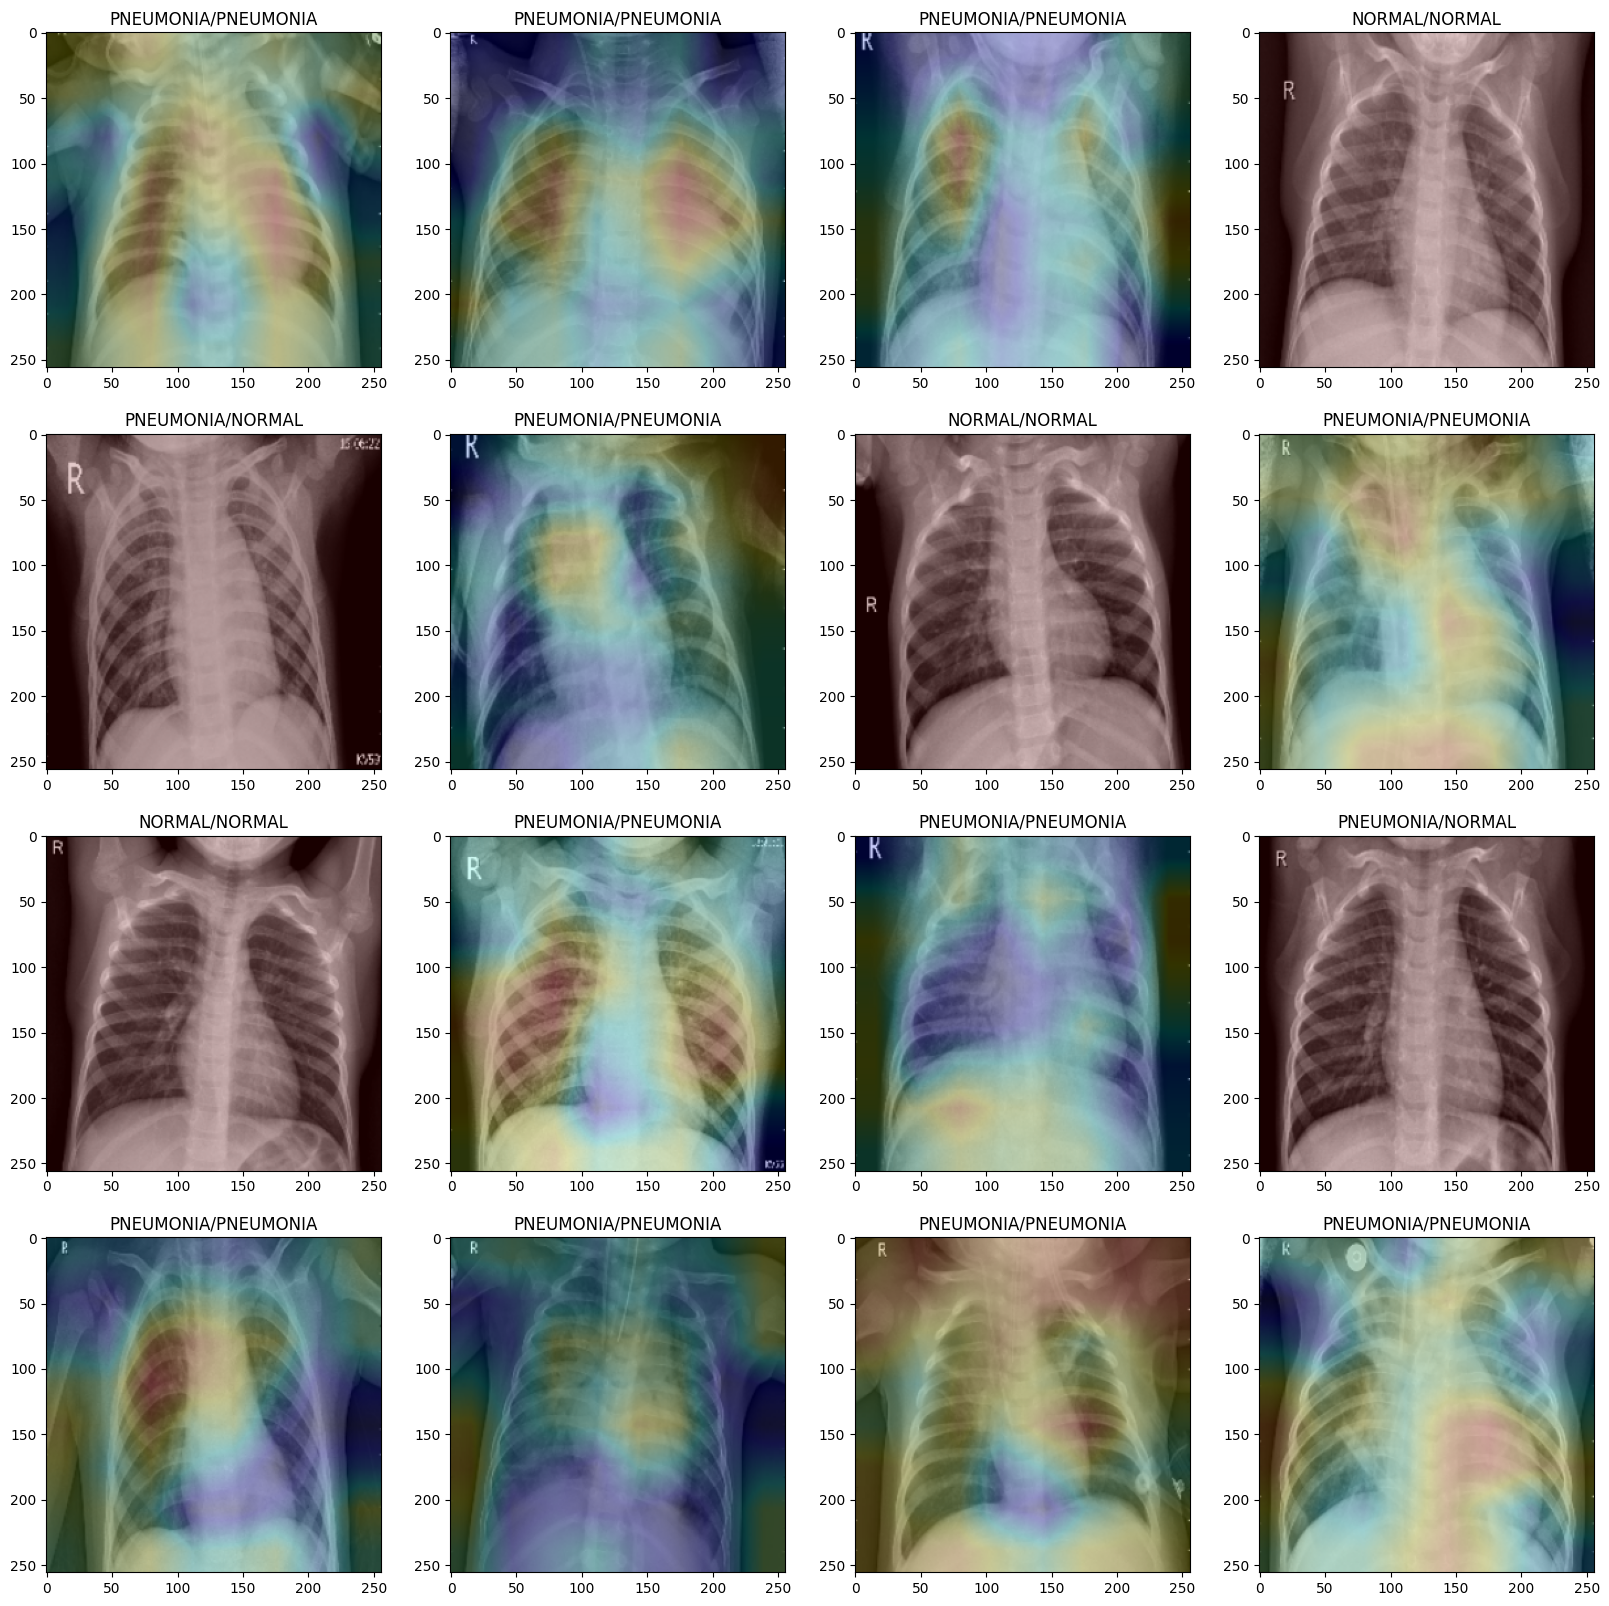

In [25]:
# Number of rows and columns in the grid of images
row, col = 4, 4

# Create a figure and subplots grid
fig, axes = plt.subplots(row, col, figsize=(20, 20))

# Iterate over a subset of the test dataset
for index, x in enumerate(test_ds.take(row * col)):

    # Unpack the input and label from the current iteration
    x_test, y_test = x

    # Resize the input image to the specified size
    x_test = tf.image.resize(x_test, IMG_SIZE)

    # Perform prediction on the resized image
    y_pred = loaded_model.predict(tf.expand_dims(x_test, axis=0), verbose=0).argmax()

    # Generate GradCAM heatmap
    grad_heatmap = gradCam.gradCAM(x_test, name='block5_pool', index_class=y_test.numpy().argmax())

    # Display the GradCAM heatmap in the corresponding subplot
    axes[index // row, index % col].imshow(grad_heatmap)

    # Set the title for the subplot
    axes[index // row, index % col].set_title(f"{CLASS_NAMES[y_pred]}/{CLASS_NAMES[y_test.numpy().argmax()]}")

    # Break the loop if all subplots have been filled
    if index == (row * col) - 1:
        break

# Display the figure with subplots
plt.show()

In [26]:
def conf_matrix(y_test=None, y_pred=None, class_names=None):

    cm = confusion_matrix(y_test, y_pred)

    fig, ax = plt.subplots(figsize=(8, 8))
    a = ax.matshow(cm, cmap=plt.cm.Greens)

    fig.colorbar(a)

    ax.set(title="Confusion Matrix",
             xlabel="Predicted label",
             ylabel="Actual label",
             xticks=np.arange(len(class_names)),
             yticks=np.arange(len(class_names)),
             xticklabels=class_names,
             yticklabels=class_names)

    ax.xaxis.set_label_position("bottom")
    ax.xaxis.tick_bottom()

    plt.xticks(rotation=60, fontsize=20)
    plt.yticks(fontsize=20)

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, f"{cm[i, j]}",
                  horizontalalignment="center", color="black" if cm[i, j] < (cm.max() + cm.min()) / 2 else "white",
                  fontsize=12)

In [27]:
y_pred = []
y_truth = []

for x, y in test:
    y_pred.extend(loaded_model.predict([x], verbose=0).round())
    y_truth.extend(y.numpy())

y_true = np.array(y_truth).argmax(axis=1)
y_prediction = np.array(y_pred).argmax(axis=1)

c:\Users\gchan\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\models\functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_24
Received: inputs=('Tensor(shape=(32, 256, 256, 3))',)
  warnings.warn(msg)
c:\Users\gchan\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\models\functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_24
Received: inputs=('Tensor(shape=(None, 256, 256, 3))',)
  warnings.warn(msg)


In [28]:
# Compute evaluation metrics
accuracy = accuracy_score(y_true, y_prediction)
precision = precision_score(y_true, y_prediction, average='macro')
recall = recall_score(y_true, y_prediction, average='macro')
f1 = f1_score(y_true, y_prediction, average='macro')
confusion_mat = confusion_matrix(y_true, y_prediction)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)
print("\nConfusion Matrix:")
print(pd.DataFrame(confusion_mat))

Accuracy: 0.8092948717948718
Precision: 0.8689693783165378
Recall: 0.7491452991452991
F1-score: 0.7665544332210998

Confusion Matrix:
     0    1
0  119  115
1    4  386


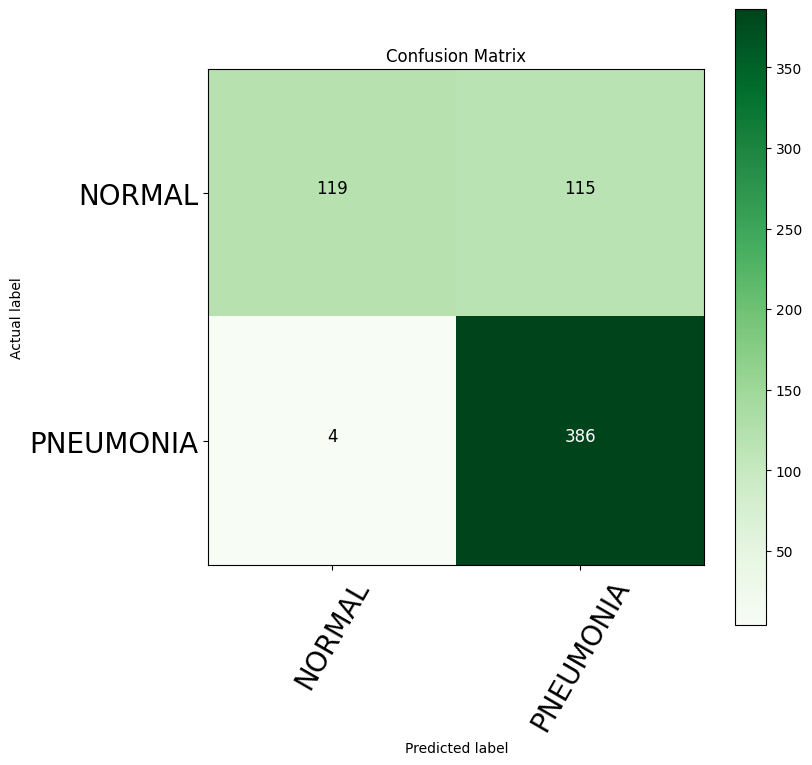

In [29]:
conf_matrix(y_test=y_true, y_pred=y_prediction, class_names=CLASS_NAMES)

# Lime

In [30]:
pip install lime


Note: you may need to restart the kernel to use updated packages.


In [1]:
def predict_fn(images):
    images = tf.image.resize(images, IMG_SIZE)
    preds = loaded_model.predict(images)
    return preds


In [2]:
import random
from lime import lime_image
from skimage.segmentation import mark_boundaries

# Get 1 sample image and label from the test dataset
for img, label in test_ds.take(5):
    sample_img = img.numpy()
    true_label = label.numpy().argmax()

# Resize to match model input size
sample_img = tf.image.resize(sample_img, IMG_SIZE).numpy().astype(np.uint8)


NameError: name 'test_ds' is not defined

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 958ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 852ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 889ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 987ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 998ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 998ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 997ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 999ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 978ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 983ms/

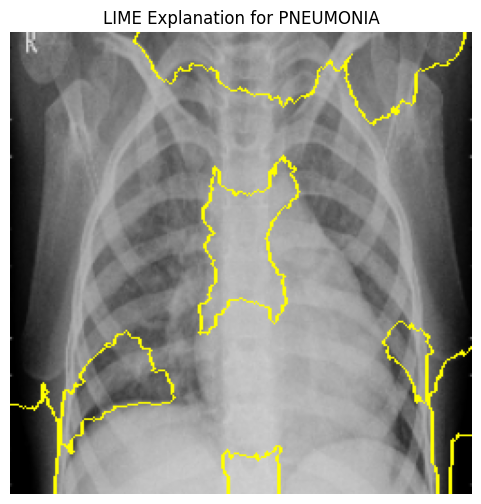

In [33]:
explainer = lime_image.LimeImageExplainer()

# Explain prediction on the image
explanation = explainer.explain_instance(
    image=sample_img,
    classifier_fn=predict_fn,
    top_labels=2,
    hide_color=0,
    num_samples=1000  # Number of perturbed samples
)

# Get image and mask for the top predicted class
lime_img, mask = explanation.get_image_and_mask(
    label=explanation.top_labels[0],
    positive_only=True,
    hide_rest=False,
    num_features=10,
    min_weight=0.0
)

# Show explanation
plt.figure(figsize=(6,6))
plt.imshow(mark_boundaries(lime_img, mask))
plt.title(f"LIME Explanation for {CLASS_NAMES[true_label]}")
plt.axis('off')
plt.show()


In [34]:
def run_lime_with_config(sample_img, predict_fn, label_index=0,
                         positive_only=True, hide_rest=False, num_features=10, num_samples=1000,
                         title="LIME Output"):
    explainer = lime_image.LimeImageExplainer()

    explanation = explainer.explain_instance(
        image=sample_img,
        classifier_fn=predict_fn,
        top_labels=1,
        hide_color=0,
        num_samples=num_samples
    )

    lime_img, mask = explanation.get_image_and_mask(
        label=explanation.top_labels[label_index],
        positive_only=positive_only,
        hide_rest=hide_rest,
        num_features=num_features
    )

    plt.figure(figsize=(6, 6))
    plt.imshow(mark_boundaries(lime_img, mask))
    plt.title(f"{title}\nFeatures: {num_features}, PosOnly: {positive_only}, HideRest: {hide_rest}, Samples: {num_samples}")
    plt.axis('off')
    plt.show()


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 942ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 994ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 983ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 993ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 984ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 983ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 977ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 990ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 971ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 981ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 993ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 988ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━

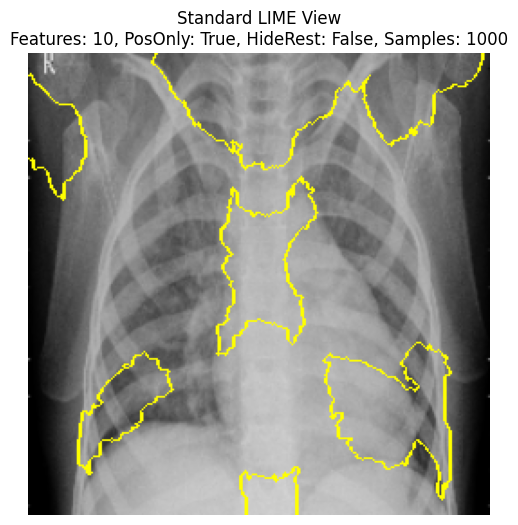

In [35]:
run_lime_with_config(sample_img, predict_fn,
                     positive_only=True, hide_rest=False, num_features=10, num_samples=1000,
                     title="Standard LIME View")


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 955ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 990ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 986ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 999ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 976ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 981ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 974ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 972ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 992ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 991ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 992ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 997ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 997ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 997ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 979ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 977ms/step
1/1 ━━━━━━━━━

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


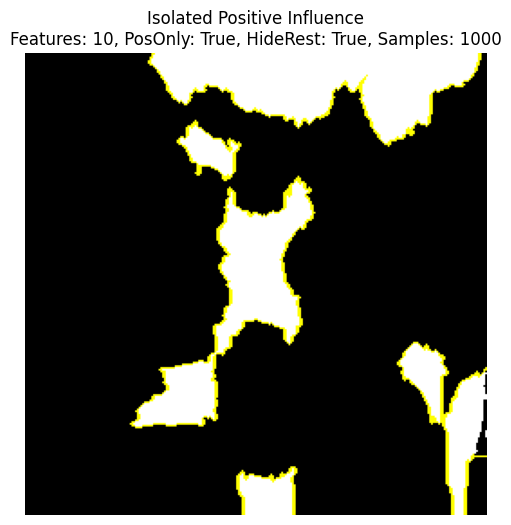

In [36]:
run_lime_with_config(sample_img, predict_fn,
                     positive_only=True, hide_rest=True, num_features=10, num_samples=1000,
                     title="Isolated Positive Influence")


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 945ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 963ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 997ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 982ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 989ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 986ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 990ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 993ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 955ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 968ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━

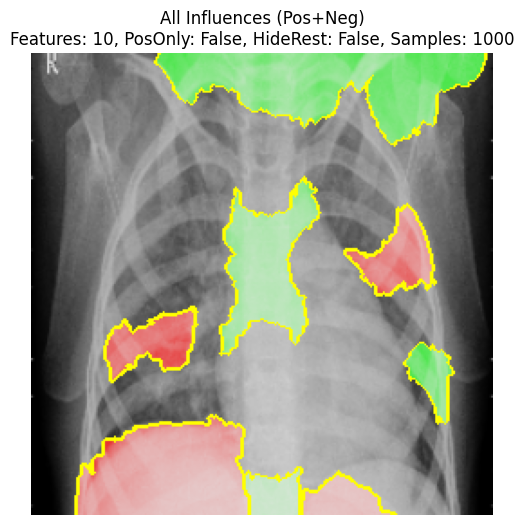

In [37]:
run_lime_with_config(sample_img, predict_fn,
                     positive_only=False, hide_rest=False, num_features=10, num_samples=1000,
                     title="All Influences (Pos+Neg)")


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 926ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 990ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━

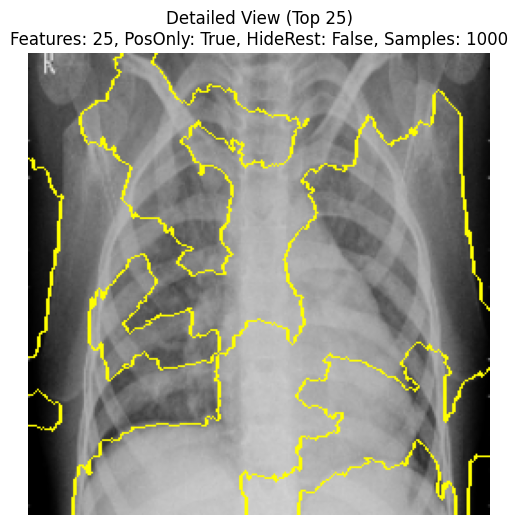

In [38]:
run_lime_with_config(sample_img, predict_fn,
                     positive_only=True, hide_rest=False, num_features=25, num_samples=1000,
                     title="Detailed View (Top 25)")


In [39]:
import matplotlib.pyplot as plt
from lime import lime_image
from skimage.segmentation import mark_boundaries

def analyze_with_lime(sample_img, predict_fn, class_label=0):
    explainer = lime_image.LimeImageExplainer()

    # Generate explanation
    explanation = explainer.explain_instance(
        image=sample_img,
        classifier_fn=predict_fn,
        top_labels=2,
        hide_color=0,
        num_samples=1000
    )

    # Prepare 5 variants with different parameters
    configs = [
        {"positive_only": True, "hide_rest": False, "num_features": 10, "title": "Positive-Only (Top 10), Background Shown"},
        {"positive_only": True, "hide_rest": True,  "num_features": 10, "title": "Positive-Only (Top 10), Background Hidden"},
        {"positive_only": False, "hide_rest": False, "num_features": 10, "title": "All Influences (Top 10)"},
        {"positive_only": True, "hide_rest": False, "num_features": 25, "title": "High Resolution (Top 25 Features)"},
    ]

    # Add low-sample explanation separately
    explanation_low_sample = explainer.explain_instance(
        image=sample_img,
        classifier_fn=predict_fn,
        top_labels=2,
        hide_color=0,
        num_samples=100  # Low sample test
    )
    lime_img_low, mask_low = explanation_low_sample.get_image_and_mask(
        label=explanation_low_sample.top_labels[0],
        positive_only=True,
        hide_rest=False,
        num_features=10
    )

    # Plot grid
    fig, axs = plt.subplots(2, 3, figsize=(18, 10))
    axs = axs.flatten()

    for idx, cfg in enumerate(configs):
        lime_img, mask = explanation.get_image_and_mask(
            label=explanation.top_labels[class_label],
            positive_only=cfg["positive_only"],
            hide_rest=cfg["hide_rest"],
            num_features=cfg["num_features"]
        )
        axs[idx].imshow(mark_boundaries(lime_img, mask))
        axs[idx].set_title(cfg["title"])
        axs[idx].axis('off')

    axs[4].imshow(mark_boundaries(lime_img_low, mask_low))
    axs[4].set_title("Low Samples (100 perturbed)")
    axs[4].axis('off')

    axs[5].axis('off')  # Empty subplot

    plt.suptitle("LIME Analysis - Various Perspectives", fontsize=16)
    plt.tight_layout()
    plt.show()


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 933ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 998ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 982ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step    
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 987ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━

  0%|          | 0/100 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 974ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step    
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


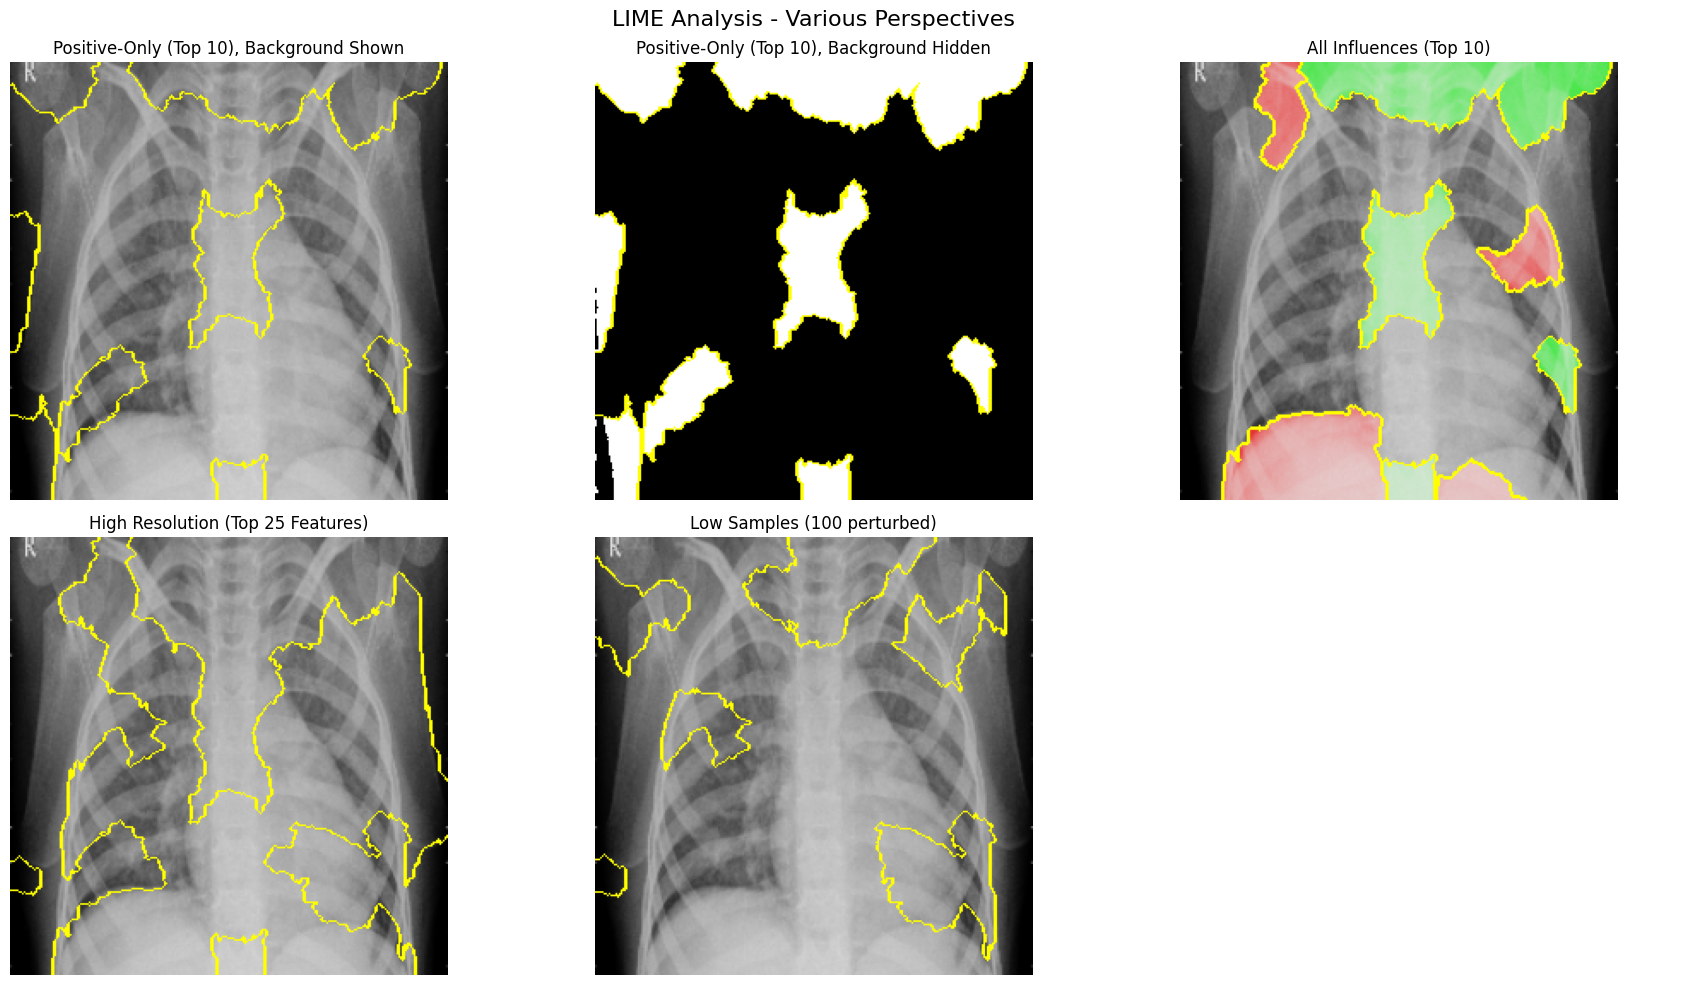

In [40]:
analyze_with_lime(sample_img, predict_fn)


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 943ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 860ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 841ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 885ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 865ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 914ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 898ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 906ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 897ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 838ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 833ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 844ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 859ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 831ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 856ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 826ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 848ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 842ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 854ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 887ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 860ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 847ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 863ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 847ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 851ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

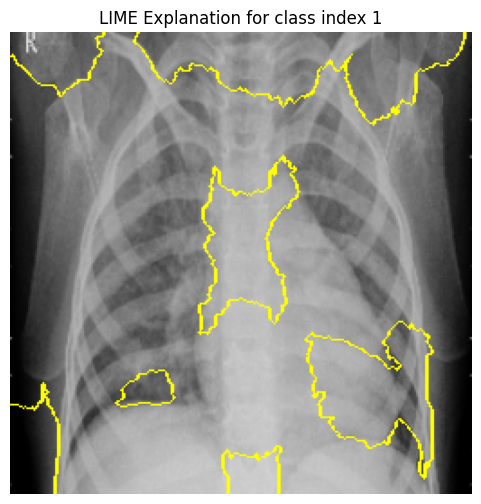

In [42]:
import numpy as np
import matplotlib.pyplot as plt
from lime import lime_image
from skimage.segmentation import mark_boundaries
from keras.applications.vgg19 import preprocess_input, decode_predictions
from keras.preprocessing import image
import cv2

def evaluate_lime_explanation(img_array, predict_fn, class_index, mask, top_n=10):
    # 1. Preprocess the original image
    preprocessed_img = preprocess_input(np.expand_dims(img_array, axis=0))
    original_pred = predict_fn(preprocessed_img)[0]
    original_conf = original_pred[class_index]

    # 2. Mask out all regions EXCEPT LIME's
    lime_only_img = img_array.copy()
    lime_only_img[~mask] = 0
    lime_only_pred = predict_fn(preprocess_input(np.expand_dims(lime_only_img, axis=0)))[0]
    print(lime_only_pred.shape)
    lime_only_conf = lime_only_pred[class_index]

    # 3. Mask OUT the LIME regions
    lime_masked_img = img_array.copy()
    lime_masked_img[mask] = 0
    lime_masked_pred = predict_fn(preprocess_input(np.expand_dims(lime_masked_img, axis=0)))[0]
    lime_masked_conf = lime_masked_pred[class_index]

    # 4. Compute drop and fidelity
    drop_conf = original_conf - lime_masked_conf
    fidelity = lime_only_conf / original_conf if original_conf > 0 else 0

    return {
        "original_conf": original_conf,
        "lime_only_conf": lime_only_conf,
        "lime_masked_conf": lime_masked_conf,
        "confidence_drop": drop_conf,
        "fidelity_score": fidelity
    }

# Example usage
explanation = explainer.explain_instance(
    image=sample_img,  # original image as NumPy array
    classifier_fn=predict_fn,
    top_labels=1,
    hide_color=0,
    num_samples=1000
)

top_label = explanation.top_labels[0]
lime_img, mask = explanation.get_image_and_mask(
    label=top_label,
    positive_only=True,
    hide_rest=False,
    num_features=10,
    min_weight=0.0
)

results = evaluate_lime_explanation(sample_img, predict_fn, top_label, mask)

# Print metrics
print("\n🔍 LIME Explanation Evaluation Metrics:")
print(f"Original Confidence:         {results['original_conf']:.4f}")
print(f"LIME-only Confidence:        {results['lime_only_conf']:.4f}")
print(f"Masked Confidence:           {results['lime_masked_conf']:.4f}")
print(f"Confidence Drop (Masked):    {results['confidence_drop']:.4f}")
print(f"Explanation Fidelity Score:  {results['fidelity_score']:.4f}")

# Optional: visualize again
plt.figure(figsize=(6,6))
plt.imshow(mark_boundaries(lime_img, mask))
plt.title(f"LIME Explanation for class index {top_label}")
plt.axis('off')
plt.show()


In [44]:
def compute_sparsity(heatmap, threshold=0.5):
    """Return sparsity = ratio of highlighted area to total."""
    binary_map = (heatmap > threshold).astype(np.uint8)
    sparsity = np.sum(binary_map) / binary_map.size
    return sparsity


In [45]:
def compute_confidence_drop(model, original_image, heatmap, preprocess_input, top_k=0.2):
    """Remove top-k% important regions and see how much confidence drops."""
    # Flatten and get threshold
    flat = heatmap.flatten()
    cutoff = np.percentile(flat, 100 * (1 - top_k))
    mask = heatmap >= cutoff

    # Apply mask (set important pixels to 0)
    masked_image = original_image.copy()
    masked_image[mask] = 0

    # Preprocess and predict
    preprocessed = preprocess_input(np.expand_dims(masked_image, axis=0))
    new_pred = model.predict(preprocessed)[0]
    old_pred = model.predict(preprocess_input(np.expand_dims(original_image, axis=0)))[0]

    drop = old_pred.max() - new_pred.max()
    return drop


In [46]:
def compute_insertion_score(model, original_image, heatmap, preprocess_input, steps=10):
    """Start from blank image, insert top regions, and track confidence growth."""
    img_shape = original_image.shape
    blank = np.zeros_like(original_image)

    flat = heatmap.flatten()
    sorted_idx = np.argsort(flat)[::-1]  # Most important first

    inserted = blank.copy()
    scores = []

    for step in range(1, steps + 1):
        k = int(step * len(sorted_idx) / steps)
        indices = np.unravel_index(sorted_idx[:k], img_shape[:2])
        inserted[indices] = original_image[indices]

        inp = preprocess_input(np.expand_dims(inserted, axis=0))
        pred = model.predict(inp)[0]
        scores.append(pred.max())

    return scores


In [50]:
def evaluate_lime_explanation(img_array, predict_fn, class_index, mask):
    preprocessed_img = preprocess_input(np.expand_dims(img_array, axis=0))
    original_pred = predict_fn(preprocessed_img)[0]
    original_conf = original_pred[class_index]

    # Only LIME region
    lime_only_img = img_array.copy()
    lime_only_img[~mask] = 0
    lime_only_pred = predict_fn(preprocess_input(np.expand_dims(lime_only_img, axis=0)))[0]
    lime_only_conf = lime_only_pred[class_index]

    # Masked LIME region
    lime_masked_img = img_array.copy()
    lime_masked_img[mask] = 0
    lime_masked_pred = predict_fn(preprocess_input(np.expand_dims(lime_masked_img, axis=0)))[0]
    lime_masked_conf = lime_masked_pred[class_index]

    # XAI Metrics
    confidence_drop = original_conf - lime_masked_conf
    fidelity_score = lime_only_conf / original_conf if original_conf > 0 else 0
    sufficiency = lime_only_conf / original_conf if original_conf > 0 else 0
    comprehensiveness = confidence_drop / original_conf if original_conf > 0 else 0

    return {
        "original_conf": original_conf,
        "lime_only_conf": lime_only_conf,
        "lime_masked_conf": lime_masked_conf,
        "confidence_drop": confidence_drop,
        "fidelity_score": fidelity_score,
        "sufficiency": sufficiency,
        "comprehensiveness": comprehensiveness
    }


In [51]:
results = evaluate_lime_explanation(sample_img, predict_fn, top_label, mask)

print("Fidelity:", results["fidelity_score"])
print("Sufficiency:", results["sufficiency"])
print("Comprehensiveness:", results["comprehensiveness"])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step
Fidelity: 0.90665483
Sufficiency: 0.90665483
Comprehensiveness: 0.56987596


In [52]:
def evaluate_lime_explanation(img_array, predict_fn, class_index, mask):
    preprocessed_img = preprocess_input(np.expand_dims(img_array, axis=0))
    original_pred = predict_fn(preprocessed_img)[0]
    original_conf = original_pred[class_index]

    # Only LIME region
    lime_only_img = img_array.copy()
    lime_only_img[~mask] = 0
    lime_only_pred = predict_fn(preprocess_input(np.expand_dims(lime_only_img, axis=0)))[0]
    lime_only_conf = lime_only_pred[class_index]

    # Masked LIME region
    lime_masked_img = img_array.copy()
    lime_masked_img[mask] = 0
    lime_masked_pred = predict_fn(preprocess_input(np.expand_dims(lime_masked_img, axis=0)))[0]
    lime_masked_conf = lime_masked_pred[class_index]

    # XAI Metrics
    confidence_drop = original_conf - lime_masked_conf
    fidelity_score = lime_only_conf / original_conf if original_conf > 0 else 0
    sufficiency = lime_only_conf / original_conf if original_conf > 0 else 0
    comprehensiveness = confidence_drop / original_conf if original_conf > 0 else 0

    return {
        "original_conf": original_conf,
        "lime_only_conf": lime_only_conf,
        "lime_masked_conf": lime_masked_conf,
        "confidence_drop": confidence_drop,
        "fidelity_score": fidelity_score,
        "sufficiency": sufficiency,
        "comprehensiveness": comprehensiveness
    }


In [ ]:
results = evaluate_lime_explanation(sample_img, predict_fn, top_label, mask)

print("\nXAI Explanation Metrics (LIME):")
print(f"Original Confidence:         {results['original_conf']:.4f}")
print(f"LIME-only Confidence:        {results['lime_only_conf']:.4f}")
print(f"Masked Confidence:           {results['lime_masked_conf']:.4f}")
print(f"Confidence Drop:             {results['confidence_drop']:.4f}")
print(f"Fidelity Score:              {results['fidelity_score']:.4f}")
print(f"Sufficiency:                 {results['sufficiency']:.4f}")
print(f"Comprehensiveness:           {results['comprehensiveness']:.4f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step

🔍 XAI Explanation Metrics (LIME):
Original Confidence:         0.9584
LIME-only Confidence:        0.8689
Masked Confidence:           0.4122
Confidence Drop:             0.5462
Fidelity Score:              0.9067
Sufficiency:                 0.9067
Comprehensiveness:           0.5699
